## Instrucciones para examen
### Objetivo: Este examen tiene como objetivo evaluar la capacidad del estudiante para limpiar, explorar, implementar y evaluar modelos de regresión en un dataset de precios de casas.

Utilizaremos el «House Prices Dataset» disponible en Kaggle. Los estudiantes deben demostrar habilidades prácticas en la manipulación de datos, creación de visualizaciones y modelado predictivo.

### Contexto y Descripción del Dataset

El «House Prices Dataset» contiene datos sobre diversas características de casas residenciales en Ames, Iowa. La tarea es predecir el precio final de cada casa (variable objetivo) en función de sus características.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb

In [2]:
# Importar librerías necesarias
import pandas as pd

# Cargar el dataset de entrenamiento
df_train = pd.read_csv('../data/train.csv')

# Mostrar las primeras filas del dataset para inspección
print(df_train.head())


   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   



### Requisitos

1. Limpieza de Datos:
- Identificación y eliminación de valores duplicados: Asegúrate de que no haya registros duplicados que puedan sesgar los resultados del análisis.
- Verificación y ajuste de tipos de datos: Verifica que cada columna tenga el tipo de dato correcto (numérico o categórico) y ajusta si es necesario.
- Corrección de inconsistencias en valores categóricos: Revisa las categorías de las variables y unifica aquellos valores que puedan estar escritos de diferentes maneras pero que representen lo mismo.
- Manejo de valores faltantes adecuadamente: Identifica y maneja los valores faltantes utilizando técnicas apropiadas como la imputación de la mediana, media o moda, según corresponda.


In [3]:
# Identificación de valores duplicados
duplicados = df_train.duplicated().sum()
print(f'Número de registros duplicados: {duplicados}')

# Eliminación de valores duplicados
df_train = df_train.drop_duplicates()


Número de registros duplicados: 0


In [4]:
# Verificamos los tipos de datos
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

*Lo primero que encontramos es una gran cantidad de datos faltantes, y procedemos a verificar* 

In [5]:
#Calculamos los valores nulos 
#Codigo Hecho por el profesor Iair Linker
def calculate_na_statistics(df: pd.DataFrame):
    qsna = df.shape[0] - df.isnull().sum(axis=0)
    qna = df.isnull().sum(axis=0)
    ppna = np.round(100 * (df.isnull().sum(axis=0) / df.shape[0]), 2)
    aux = {'datos sin NAs en q': qsna, 'Na en q': qna, 'Na en %': ppna}
    na = pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %', ascending=False)

null_values = calculate_na_statistics(df_train)
null_values

,datos sin NAs en q,Na en q,Na en %
PoolQC,7,1453,99.52
MiscFeature,54,1406,96.30
Alley,91,1369,93.77
Fence,281,1179,80.75
MasVnrType,588,872,59.73
...,...,...,...
ExterQual,1460,0,0.00
Exterior2nd,1460,0,0.00
Exterior1st,1460,0,0.00
RoofMatl,1460,0,0.00


In [6]:
# imprimo solo los valores nulos con mas de 50% de los datos
valores_na_50 = pd.DataFrame(null_values[null_values['Na en %'] > 50])
valores_na_50


,datos sin NAs en q,Na en q,Na en %
PoolQC,7,1453,99.52
MiscFeature,54,1406,96.30
Alley,91,1369,93.77
Fence,281,1179,80.75
MasVnrType,588,872,59.73


**Con este dato me fui a mirar data_description y encontre datos para rellenar sin eliminar valores**

verifique una de las columnas con una columna relacionada, PoolQC por ser la que mas valores nulos tiene

In [7]:
#Aca vemos que los valores nulos en poolQC son los que no tienen piscina y por eso cuando PoolArea es mayor que 0, si tiene piscina y tenemos los datos
filtro_piscina = df_train['PoolArea'] > 0
df_train[['PoolArea', 'PoolQC']][filtro_piscina]


,PoolArea,PoolQC
197,512,Ex
810,648,Fa
1170,576,Gd
1182,555,Ex
1298,480,Gd
1386,519,Fa
1423,738,Gd


In [8]:
#relleno los valores nulos encontrados en nuestro data_description
#Primero hecho por mi y optimizado por Claude AI
# Create a dictionary mapping columns to their fill values
fill_values = {
    'PoolQC': 'No Pool',
    'MiscFeature': 'None',
    'Alley': 'No alley access',
    'Fence': 'No Fence',
    'MasVnrType': 'Unknown',
    'FireplaceQu': 'No Fireplace',
    'GarageFinish': 'No Garage',
    'GarageType': 'No Garage',
    'GarageQual': 'No Garage',
    'GarageCond': 'No Garage',
    'BsmtFinType2': 'No Basement',
    'BsmtExposure': 'No Basement',
    'BsmtQual': 'No Basement',
    'BsmtCond': 'No Basement',
    'BsmtFinType1': 'No Basement'
}

# Apply all fill operations at once
df_train = df_train.fillna(fill_values)

In [9]:
#Volvemos a calcular los valores nulos para verificar que se hayan rellenado correctamente
null_values = calculate_na_statistics(df_train)
null_values[null_values['Na en %'] > 0]

,datos sin NAs en q,Na en q,Na en %
LotFrontage,1201,259,17.74
GarageYrBlt,1379,81,5.55
MasVnrArea,1452,8,0.55
Electrical,1459,1,0.07


In [10]:
#Comenzamos a entender los valores nulos de la variable LotFrontage
df_train['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [11]:
#valores no nulos en LotFrontage agrupados por LotConfig y con la media de LotArea
filt_not_null = df_train['LotFrontage'] != np.nan
df_train[['LotFrontage', 'LotArea', 'LotConfig']][filt_not_null].groupby(['LotConfig']).mean()

,LotFrontage,LotArea
LotConfig,,
Corner,84.039801,11426.231939
CulDSac,59.911111,17342.053191
FR2,63.515152,10398.276596
FR3,70.750000,8706.250000
Inside,67.715686,9691.799430


In [12]:
#valores nulos en LotFrontage agrupados por LotConfig y con la media de LotArea
null_lotfront = df_train['LotFrontage'].isnull()
df_train[['LotFrontage', 'LotArea', 'LotConfig']][null_lotfront].groupby(['LotConfig']).mean()

,LotFrontage,LotArea
LotConfig,,
Corner,NaN,14445.177419
CulDSac,NaN,19110.836735
FR2,NaN,12206.357143
Inside,NaN,10445.208955


In [13]:
#vemos si tienen correlacion con LotArea
df_train[['LotFrontage', 'LotArea']].corr()
#encontramos poca correlacion por eso decidimos por ahora ignorar

,LotFrontage,LotArea
LotFrontage,1.000000,0.426095
LotArea,0.426095,1.000000


### Concluimos la limpieza de datos, los demas datos nulos vamos a imputar con el modelo.

In [ ]:
#Verificamos los tipos de variables
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 87 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Id               1460 non-null   int64   
 1   MSSubClass       1460 non-null   int64   
 2   MSZoning         1460 non-null   category
 3   LotFrontage      1201 non-null   float64 
 4   LotArea          1460 non-null   int64   
 5   Street           1460 non-null   category
 6   Alley            1460 non-null   category
 7   LotShape         1460 non-null   category
 8   LandContour      1460 non-null   category
 9   Utilities        1460 non-null   category
 10  LotConfig        1460 non-null   category
 11  LandSlope        1460 non-null   category
 12  Neighborhood     1460 non-null   category
 13  Condition1       1460 non-null   category
 14  Condition2       1460 non-null   category
 15  BldgType         1460 non-null   category
 16  HouseStyle       1460 non-null   category


In [ ]:
#Verificamos los tipos de variables numéricas
numerical_columns = df_train.select_dtypes(include=[np.number]).columns
numerical_columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [16]:
#Corregimos de manera independiente la variable Booleana que encontramos
df_train['CentralAir'] = df_train['CentralAir'].astype('bool')

In [17]:
#Transformar las columnas de tipo 'object' a 'category'
for column in df_train.columns:
    if df_train[column].dtype == 'object':
        df_train[column] = df_train[column].astype('category')

# Codigo hecho por el profesor Iair Linker
# Identificar columnas de tipo 'object', típicamente usadas para variables categóricas
categorical_columns = df_train.select_dtypes(include=['category','bool']).columns
# Crear un diccionario donde cada clave es el nombre de la columna y los valores son los valores únicos de esa columna
unique_values_dict = {col: df_train[col].unique() for col in categorical_columns}
# Convertir el diccionario en un DataFrame, rellenando con NaN cuando haya menos valores únicos
unique_values_df = pd.DataFrame.from_dict(unique_values_dict, orient='index').transpose()
# Mostrar el DataFrame resultante
unique_values_df.T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
MSZoning,RL,RM,C (all),FV,RH,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Street,Pave,Grvl,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Alley,No alley access,Grvl,Pave,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
LotShape,Reg,IR1,IR2,IR3,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
LandContour,Lvl,Bnk,Low,HLS,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Utilities,AllPub,NoSeWa,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
LotConfig,Inside,FR2,Corner,CulDSac,FR3,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
LandSlope,Gtl,Mod,Sev,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Neighborhood,CollgCr,Veenker,Crawfor,NoRidge,Mitchel,Somerst,NWAmes,OldTown,BrkSide,Sawyer,...,Edwards,Timber,Gilbert,StoneBr,ClearCr,NPkVill,Blmngtn,BrDale,SWISU,Blueste
Condition1,Norm,Feedr,PosN,Artery,RRAe,RRNn,RRAn,PosA,RRNe,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
#Aca verificamos que los datos esten en el formato correcto
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   int64   
 2   MSZoning       1460 non-null   category
 3   LotFrontage    1201 non-null   float64 
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   category
 6   Alley          1460 non-null   category
 7   LotShape       1460 non-null   category
 8   LandContour    1460 non-null   category
 9   Utilities      1460 non-null   category
 10  LotConfig      1460 non-null   category
 11  LandSlope      1460 non-null   category
 12  Neighborhood   1460 non-null   category
 13  Condition1     1460 non-null   category
 14  Condition2     1460 non-null   category
 15  BldgType       1460 non-null   category
 16  HouseStyle     1460 non-null   category
 17  OverallQual    1460 non-null   in

In [19]:
#Codigo para detectar outliers usando el IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return True for outliers
    return (data < lower_bound) | (data > upper_bound)

In [20]:
# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in numerical_columns:
    outliers = detect_outliers_iqr(df_train[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': df_train[column][~outliers].min(),
        'Upper Bound': df_train[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
Id,0.0,0.000000,1.0,1460.0
MSSubClass,103.0,7.054795,20.0,120.0
LotFrontage,88.0,6.027397,30.0,111.0
LotArea,69.0,4.726027,1491.0,17671.0
OverallQual,2.0,0.136986,2.0,10.0
OverallCond,125.0,8.561644,4.0,7.0
YearBuilt,7.0,0.479452,1885.0,2010.0
YearRemodAdd,0.0,0.000000,1950.0,2010.0
MasVnrArea,96.0,6.575342,0.0,415.0
BsmtFinSF1,7.0,0.479452,0.0,1767.0


### Concluimos con la correcion de tipos de datos y podemos proceder a la exploracion de los datos.


## 2. Exploración de Datos:
- Visualizaciones univariadas y multivariadas: Crea histogramas, gráficos de barras, diagramas de dispersión y mapas de calor para entender la distribución y las relaciones entre las variables.
- Estadísticas descriptivas: Calcula medidas de tendencia central (media, mediana, moda) y de dispersión (rango, desviación estándar) para cada característica del dataset.



### **Basado en el dataset, identificamos los factores más importantes que típicamente tienen la mayor influencia en los precios de las casas. Estas son las características más influyentes, organizadas por importancia:**

### **Factores Primarios:**

**Relacionados con el Tamaño:**

* GrLivArea (Área habitable sobre el suelo)
* TotalBsmtSF (Área total del sótano)
* 1stFlrSF (Área del primer piso)
* LotArea (Tamaño total del lote)
  
  


         GrLivArea        LotArea  TotalBsmtSF     1stFlrSF     2ndFlrSF
count  1460.000000    1460.000000  1460.000000  1460.000000  1460.000000
mean   1515.463699   10516.828082  1057.429452  1162.626712   346.992466
std     525.480383    9981.264932   438.705324   386.587738   436.528436
min     334.000000    1300.000000     0.000000   334.000000     0.000000
25%    1129.500000    7553.500000   795.750000   882.000000     0.000000
50%    1464.000000    9478.500000   991.500000  1087.000000     0.000000
75%    1776.750000   11601.500000  1298.250000  1391.250000   728.000000
max    5642.000000  215245.000000  6110.000000  4692.000000  2065.000000


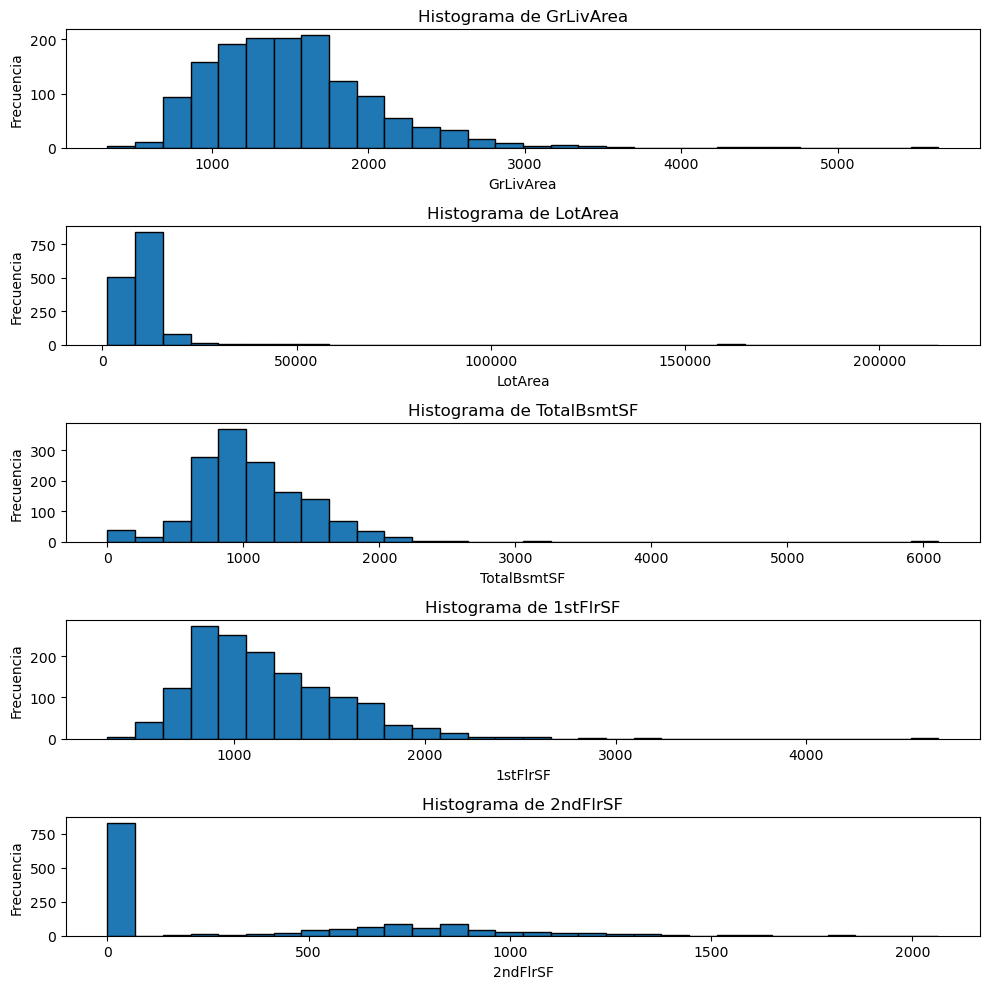

In [21]:
# Columnas relacianadas con el tamano
size_related = ['GrLivArea', 'LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
# vemos los tipos de datos de size_related
df_train[size_related].dtypes

print(df_train[size_related].describe())

# Configuración del tamaño de la gráfica
plt.figure(figsize=(10, 10))

# Crear un histograma para cada columna numérica
for i, column in enumerate(size_related, 1):
    plt.subplot(len(size_related), 1, i)
    plt.hist(df_train[column].dropna(), bins=30, edgecolor='black')
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

**Conclusion**
Los datos indican que la mayoría de las casas tienen áreas habitables moderadas y lotes pequeños a medianos. Las áreas de sótanos y primeros pisos muestran una distribución similar, con predominancia de áreas moderadas. 
Muchas casas no tienen un segundo piso, y las que tienen, tienen áreas relativamente pequeñas. 
La variabilidad en las áreas de lote es alta debido a algunos lotes excepcionalmente grandes.

### **Métricas de Calidad:**

* OverallQual (Calidad general del material y acabado)
* KitchenQual (Calidad de la cocina)
* ExterQual (Calidad del material exterior)
* BsmtQual (Altura/calidad del sótano)


OverallQual       int64
KitchenQual    category
BsmtQual       category
ExterQual      category
dtype: object
       OverallQual
count  1460.000000
mean      6.099315
std       1.382997
min       1.000000
25%       5.000000
50%       6.000000
75%       7.000000
max      10.000000


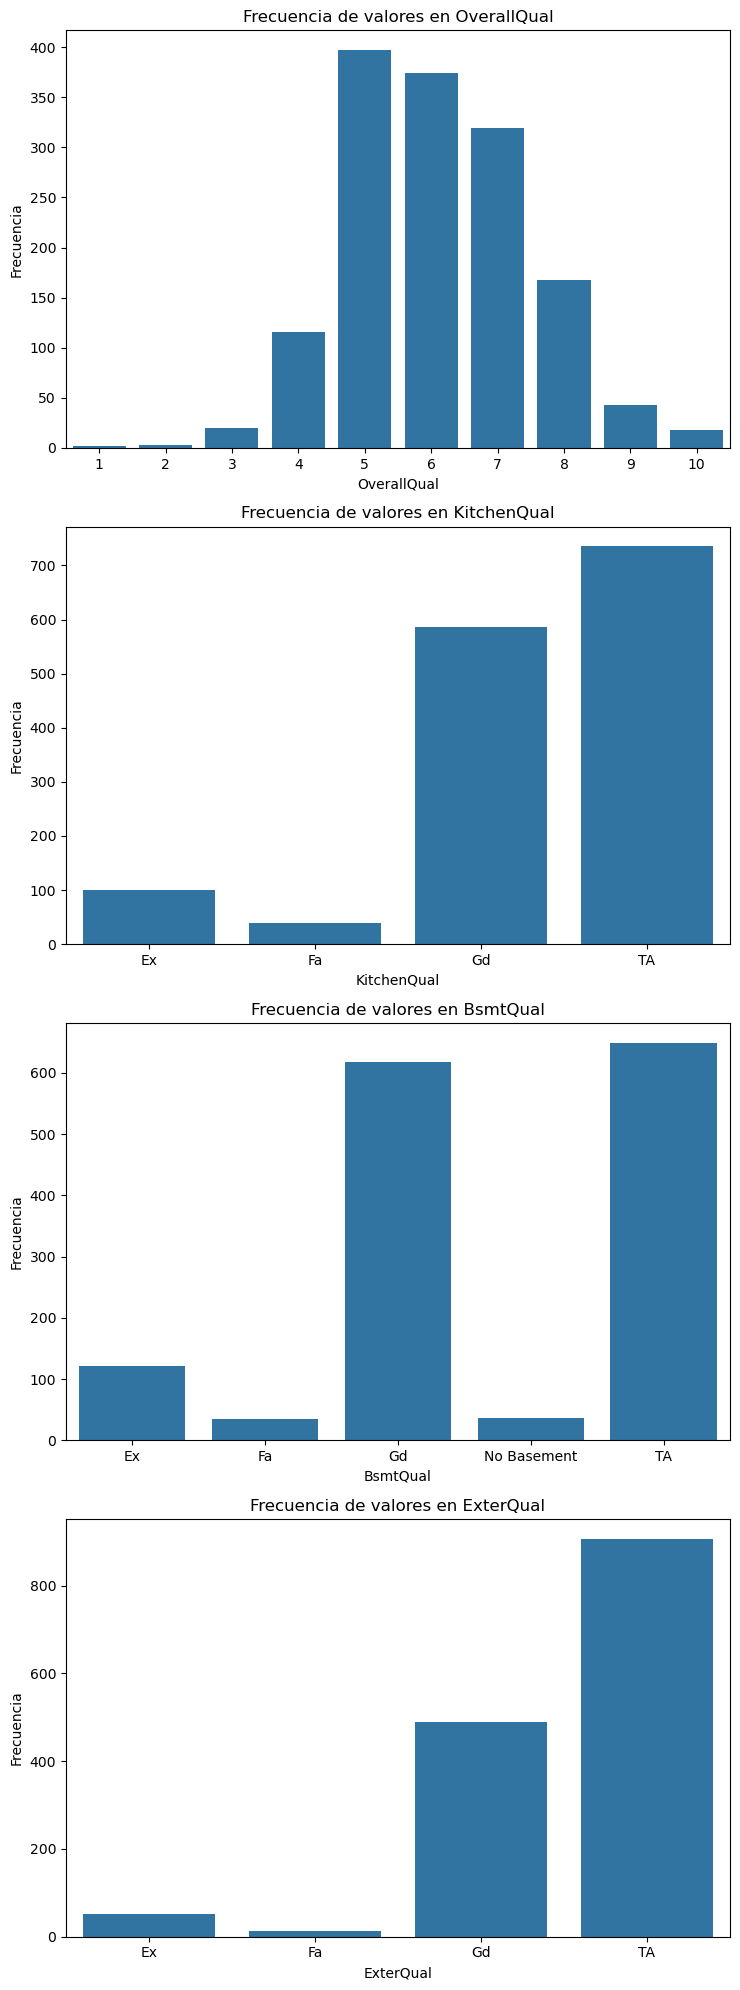

In [22]:
# Columnas relacianadas con la calidad
qual_related = ['OverallQual', 'KitchenQual', 'BsmtQual', 'ExterQual']
# vemos los tipos de datos de size_related
print(df_train[qual_related].dtypes)

print(df_train[qual_related].describe())

# Configuración del tamaño de la gráfica
plt.figure(figsize=(7.5, 5 * len(qual_related)))
# Crear un gráfico de conteo para cada columna booleana
for i, column in enumerate(qual_related, 1):
    plt.subplot(len(qual_related), 1, i)
    sns.countplot(x=df_train[column])
    plt.title(f'Frecuencia de valores en {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


**Conclusion**
La mayoría de las casas tienen calidades promedio o buenas en todas las categorías, con pocas casas en los extremos de la escala de calidad. Esto quiere sugiere que las propiedades están en condiciones bastante decentes.

### **Ubicación:**

* Neighborhood (Vecindario)
* MSZoning (Clasificación de la zona)

Neighborhood    category
MSZoning        category
dtype: object
       Neighborhood MSZoning
count          1460     1460
unique           25        5
top           NAmes       RL
freq            225     1151


C:\Users\diego\AppData\Local\Temp\ipykernel_5544\2480250480.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Figure size 1500x1000 with 0 Axes>

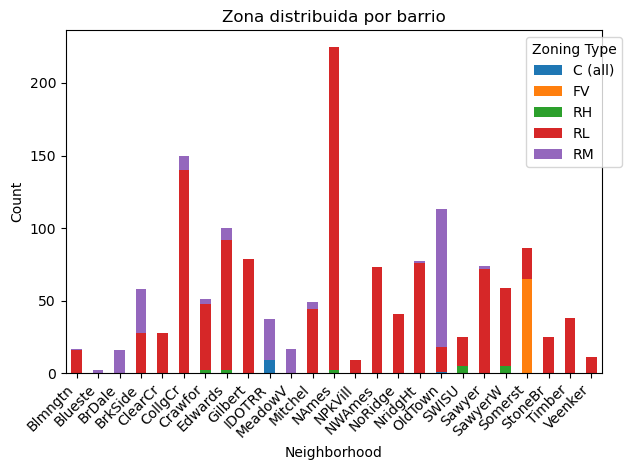

C:\Users\diego\AppData\Local\Temp\ipykernel_5544\2480250480.py:29: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



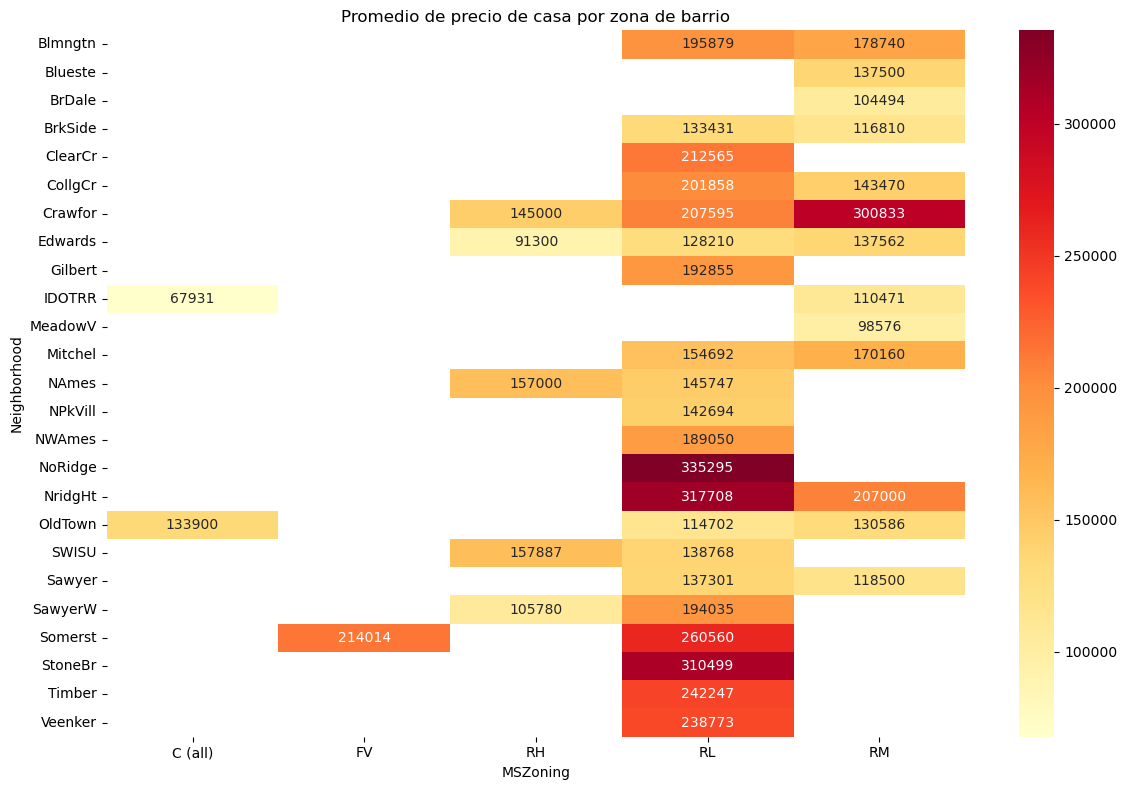

C:\Users\diego\AppData\Local\Temp\ipykernel_5544\2480250480.py:36: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [39]:
#graficos planeados por mi, optimizados por Claude AI
# Columnas relacianadas con la ubicacion
local_related = ['Neighborhood', 'MSZoning']
# vemos los tipos de datos de local_related
print(df_train[local_related].dtypes)

print(df_train[local_related].describe())


def analyze_location_features(df):
    # Create figure with subplots
    plt.figure(figsize=(15, 10))
    
    # 1. Zoning distribution by neighborhood
    neighborhood_zoning = df.groupby(['Neighborhood', 'MSZoning']).size().unstack(fill_value=0)
    
    # Plot as a stacked bar chart
    ax = neighborhood_zoning.plot(kind='bar', stacked=True)
    plt.title('Zona distribuida por barrio')
    plt.xlabel('Neighborhood')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Zoning Type', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()
    
    # 2. Average price heatmap
    plt.figure(figsize=(12, 8))
    price_by_location = df.groupby(['Neighborhood', 'MSZoning'])['SalePrice'].mean().unstack()
    sns.heatmap(price_by_location, annot=True, fmt='.0f', cmap='YlOrRd')
    plt.title('Promedio de precio de casa por zona de barrio')
    plt.tight_layout()
    plt.show()
    
    # 3. Interactive visualization with Plotly
    location_summary = df.groupby('Neighborhood').agg({
        'SalePrice': ['mean', 'count', 'std'],
        'MSZoning': lambda x: x.mode()[0]  # Most common zoning type
    }).reset_index()
    
    # Flatten column names
    location_summary.columns = ['Neighborhood', 'AvgPrice', 'Count', 'StdPrice', 'MainZoning']
    
    fig = px.scatter(location_summary, 
                    x='AvgPrice', 
                    y='Count',
                    size='StdPrice',
                    color='MainZoning',
                    hover_data=['Neighborhood'],
                    title='Analisis de barrio')
    
    fig.update_layout(
        xaxis_title="Promedio de Precio",
        yaxis_title="Numero de casas",
        height=600
    )
    fig.show()

# Usage:
analyze_location_features(df_train)

**Conclusion**
Podemos ve que hay una mayor cantidad en Residential Low density y se distribuye en un promedio de precio general entre 200k a 250k, y una acumulacion de nuevo entre los 300k y 350k


**Edad y Condición:**

* YearBuilt (Año de construcción original)
* YearRemodAdd (Año de remodelación o adición)
* OverallCond (Condición general del edificio)


YearBuilt       int64
YearRemodAdd    int64
OverallCond     int64
dtype: object
         YearBuilt  YearRemodAdd  OverallCond
count  1460.000000   1460.000000  1460.000000
mean   1971.267808   1984.865753     5.575342
std      30.202904     20.645407     1.112799
min    1872.000000   1950.000000     1.000000
25%    1954.000000   1967.000000     5.000000
50%    1973.000000   1994.000000     5.000000
75%    2000.000000   2004.000000     6.000000
max    2010.000000   2010.000000     9.000000


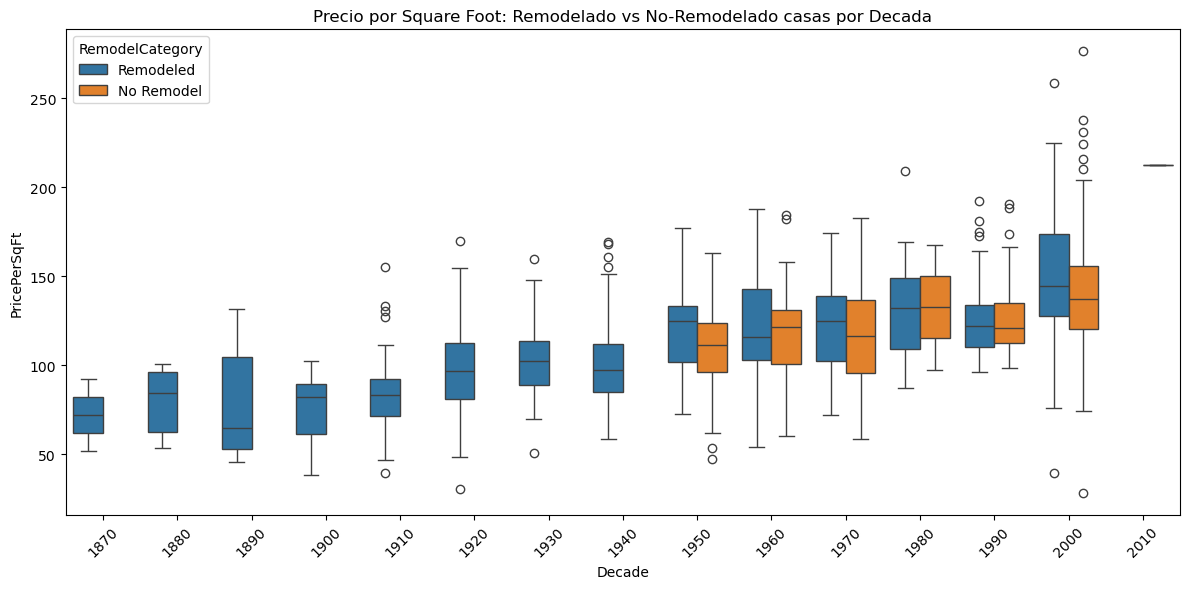

In [42]:
#graficos planeados por mi, optimizados por Claude AI
# Columnas relacianadas con la Edad y Condicion
year_cond_related = ['YearBuilt', 'YearRemodAdd','OverallCond']
# vemos los tipos de datos de year_cond_related
print(df_train[year_cond_related].dtypes)

print(df_train[year_cond_related].describe())


import plotly.graph_objects as go
from plotly.subplots import make_subplots


def analyze_time_condition(df):
    # 1. Distribution of houses by decade with price overlay
    df['Decade'] = (df['YearBuilt'] // 10) * 10
    
    fig1 = px.box(df, x='Decade', y='SalePrice',
                  title='Distribucion de precio de casas por decada de construccion')
    
    fig1.update_layout(
        xaxis_title="Construction Decade",
        yaxis_title="Sale Price",
        showlegend=True,
        height=600
    )
    fig1.show()
    
    # 2. Remodeling Impact Analysis
    fig2 = go.Figure()
    
    # Calculate years between construction and remodeling
    df['YearsToRemodel'] = df['YearRemodAdd'] - df['YearBuilt']
    
    # Create scatter plot
    fig2.add_trace(go.Scatter(
        x=df['YearBuilt'],
        y=df['SalePrice'],
        mode='markers',
        name='No Remodel',
        marker=dict(
            color='blue',
            size=8,
            opacity=0.6
        )
    ))
    
    # Highlight remodeled houses
    remodeled = df[df['YearBuilt'] != df['YearRemodAdd']]
    fig2.add_trace(go.Scatter(
        x=remodeled['YearBuilt'],
        y=remodeled['SalePrice'],
        mode='markers',
        name='Remodeled',
        marker=dict(
            color='red',
            size=8,
            opacity=0.6
        )
    ))
    
    fig2.update_layout(
        title='Precio de casas: Anho de Construccion Original vs Casa remodelada',
        xaxis_title='Year Built',
        yaxis_title='Sale Price',
        height=600
    )
    fig2.show()
    
    # 3. Condition Analysis
    fig3 = make_subplots(rows=1, cols=2, 
                        subplot_titles=('Distribucion de precio por condicion',
                                      'Calificación de Condición por Edad'))
    
    # Box plot of prices by condition
    fig3.add_trace(
        go.Box(x=df['OverallCond'].astype(str), 
               y=df['SalePrice'],
               name='Price Distribution'),
        row=1, col=1
    )
    
    # Average condition by construction decade
    condition_by_decade = df.groupby('Decade')['OverallCond'].mean().reset_index()
    
    fig3.add_trace(
        go.Scatter(x=condition_by_decade['Decade'],
                  y=condition_by_decade['OverallCond'],
                  mode='lines+markers',
                  name='Avg Condition'),
        row=1, col=2
    )
    
    fig3.update_layout(
        height=500,
        title_text='Análisis General de Condición',

        showlegend=False
    )
    
    fig3.update_xaxes(title_text="Condition Rating", row=1, col=1)
    fig3.update_xaxes(title_text="Construction Decade", row=1, col=2)
    fig3.update_yaxes(title_text="Sale Price", row=1, col=1)
    fig3.update_yaxes(title_text="Average Condition Rating", row=1, col=2)
    
    fig3.show()

# Additional analysis function for remodeling impact
def analyze_remodeling_impact(df):
    # Calculate price per square foot
    df['PricePerSqFt'] = df['SalePrice'] / df['GrLivArea']
    
    # Create remodeling categories
    df['RemodelCategory'] = 'No Remodel'
    df.loc[df['YearBuilt'] != df['YearRemodAdd'], 'RemodelCategory'] = 'Remodeled'
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Decade', y='PricePerSqFt', hue='RemodelCategory', data=df)
    plt.title('Precio por Square Foot: Remodelado vs No-Remodelado casas por Decada')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Usage:
analyze_time_condition(df_train)
analyze_remodeling_impact(df_train)

**Cocnlusion**
* Cómo varían los valores de las casas según la época de construcción
* El impacto de las remodelaciones en los precios de las casas
* La relación entre la edad y la condición de una casa
* Si las casas más nuevas tienen precios más altos por pie cuadrado
* Cómo las calificaciones de condición afectan los precios de venta 



**Amenidades Clave:**

* GarageCars (Capacidad del garaje)
* GarageArea (Tamaño del garaje)
* FullBath (Número de baños completos)
* TotRmsAbvGrd (Número total de habitaciones sobre el nivel del suelo)


GarageCars      int64
GarageArea      int64
FullBath        int64
TotRmsAbvGrd    int64
dtype: object
        GarageCars   GarageArea     FullBath  TotRmsAbvGrd
count  1460.000000  1460.000000  1460.000000   1460.000000
mean      1.767123   472.980137     1.565068      6.517808
std       0.747315   213.804841     0.550916      1.625393
min       0.000000     0.000000     0.000000      2.000000
25%       1.000000   334.500000     1.000000      5.000000
50%       2.000000   480.000000     2.000000      6.000000
75%       2.000000   576.000000     2.000000      7.000000
max       4.000000  1418.000000     3.000000     14.000000


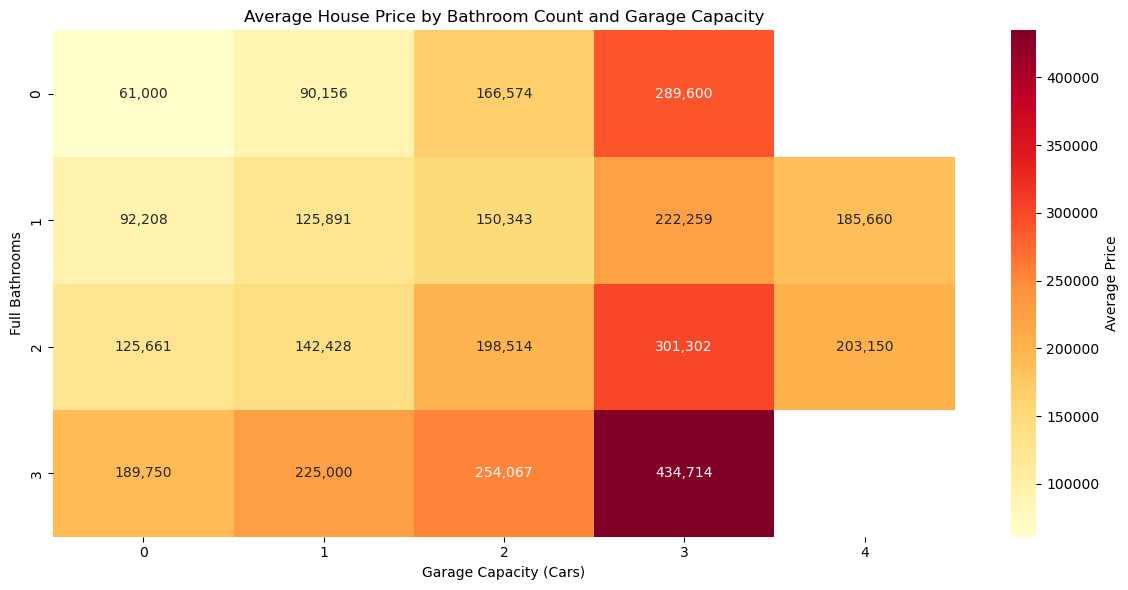

In [ ]:
#graficos planeados por mi, optimizados por Claude AI
# Columnas relacionadas con la Amenidades
amen_related = ['GarageCars','GarageArea','FullBath','TotRmsAbvGrd']
# vemos los tipos de datos de amen_related
print(df_train[amen_related].dtypes)

print(df_train[amen_related].describe())

import plotly.graph_objects as go
from plotly.subplots import make_subplots

def analyze_key_amenities(df):
    # 1. Distribution and Price Impact of Garage Features
    fig1 = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Precio por Capacidad de Garaje', 'Distribución del Área del Garaje', 'Coches de Garaje vs Área', 'Precio Promedio por Coches de Garaje')
    )
    
    # Box plot of prices by garage capacity
    fig1.add_trace(
        go.Box(x=df['GarageCars'].astype(str), y=df['SalePrice'],
               name='Distribucion de Precio'),
        row=1, col=1
    )
    
    # Histogram of garage areas
    fig1.add_trace(
        go.Histogram(x=df['GarageArea'], nbinsx=30,
                    name='Area de Garaje Dist'),
        row=1, col=2
    )
    
    # Scatter plot of garage cars vs area
    fig1.add_trace(
        go.Scatter(x=df['GarageArea'], y=df['GarageCars'],
                  mode='markers', opacity=0.6,
                  name='Autos vs Area'),
        row=2, col=1
    )
    
    # Average price by garage capacity
    avg_price_by_garage = df.groupby('GarageCars')['SalePrice'].mean()
    fig1.add_trace(
        go.Bar(x=avg_price_by_garage.index.astype(str),
               y=avg_price_by_garage.values,
               name='Precio Promedio'),
        row=2, col=2
    )
    
    fig1.update_layout(height=800, title_text="Analisis de Garage", showlegend=False)
    fig1.show()
    
    # 2. Bathroom and Room Analysis
    fig2 = go.Figure()
    
    # Create size categories for better visualization
    df['SizeCategory'] = pd.qcut(df['GrLivArea'], q=5, labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'])
    
    # Create scatter plot with size categories
    for category in df['SizeCategory'].unique():
        mask = df['SizeCategory'] == category
        fig2.add_trace(go.Scatter(
            x=df[mask]['TotRmsAbvGrd'],
            y=df[mask]['FullBath'],
            mode='markers',
            name=category,
            marker=dict(size=8, opacity=0.6),
            text=df[mask]['SalePrice'].apply(lambda x: f'${x:,.0f}')
        ))
    
    fig2.update_layout(
        title='Habitaciones vs Baños por Tamaño de Casa',
        xaxis_title='Total de Habitaciones Sobre el Nivel del Suelo',
        yaxis_title='Baños Completos',
        height=600
    )
    fig2.show()
    
    # 3. Price Per Room Analysis
    fig3 = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Precio por Habitación por Cantidad de Baños',
                       'Distribución del Número de Habitaciones')
    )
    
    # Calculate price per room
    df['PricePerRoom'] = df['SalePrice'] / df['TotRmsAbvGrd']
    
    # Box plot of price per room by bathroom count
    fig3.add_trace(
        go.Box(x=df['FullBath'].astype(str),
               y=df['PricePerRoom'],
               name='Price per Room'),
        row=1, col=1
    )
    
    # Room count distribution
    room_counts = df['TotRmsAbvGrd'].value_counts().sort_index()
    fig3.add_trace(
        go.Bar(x=room_counts.index.astype(str),
               y=room_counts.values,
               name='Room Count'),
        row=1, col=2
    )
    
    fig3.update_layout(
        height=500,
        title_text="Room Analysis",
        showlegend=False
    )
    fig3.show()

def create_amenities_summary(df):
    # Create a summary of amenities impact on price
    plt.figure(figsize=(12, 6))
    
    # Calculate average price for different combinations
    amenities_summary = df.groupby(['FullBath', 'GarageCars'])['SalePrice'].mean().reset_index()
    
    # Create pivot table for heatmap
    pivot_data = amenities_summary.pivot(
        index='FullBath',
        columns='GarageCars',
        values='SalePrice'
    )
    
    # Create heatmap
    sns.heatmap(pivot_data, annot=True, fmt=',.0f', cmap='YlOrRd',
                cbar_kws={'label': 'Average Price'})
    
    plt.title('Average House Price by Bathroom Count and Garage Capacity')
    plt.xlabel('Garage Capacity (Cars)')
    plt.ylabel('Full Bathrooms')
    plt.tight_layout()
    plt.show()

# Usage:
analyze_key_amenities(df_train)
create_amenities_summary(df_train)

**Conclusion**

* Cómo la capacidad del garaje afecta el precio de la casa
* La relación entre el tamaño de la casa y el número de baños
* Las proporciones óptimas de habitaciones a baños
* Las primas de precio por comodidades adicionales
* Las combinaciones comunes de comodidades



### Estos factores tienden a ser los más significativos porque:

* Los pies cuadrados (área habitable, tamaño del lote) impactan directamente en la utilidad y el valor.
* Las calificaciones de calidad influyen fuertemente en la percepción del comprador y la longevidad.
* La ubicación determina la accesibilidad, las escuelas y el valor de la comunidad.
* La edad y la condición afectan los costos de mantenimiento y las necesidades de modernización.
* Las comodidades básicas como garajes y baños son esenciales para la vida diaria.



1. Implementación de Modelos:
- Modelos de Regresión: Implementa modelos de Linear Regression y LightGBM (LGBM).
- Evaluación de Modelos: Evalúa los modelos utilizando métricas como MSE, RMSE, y R^2.
- Comparación de Rendimiento: Compara los resultados de ambos modelos y discute cuál es el más adecuado para este dataset.


In [46]:
#Seleccionamos las columnas numéricas y categóricas
numeric_columns = df_train[['GrLivArea','TotalBsmtSF', '1stFlrSF', 'LotArea' ,'OverallQual' ,'YearBuilt' ,'YearRemodAdd' ,'OverallCond' ,'GarageCars' ,'GarageArea' ,'FullBath' ,'TotRmsAbvGrd']]
categ_columns = df_train[['KitchenQual' ,'ExterQual','BsmtQual','Neighborhood','MSZoning']]

# Concatenar columnas numéricas y categóricas
X = pd.concat([numeric_columns, categ_columns], axis=1)
y = df_train['SalePrice']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Definir los transformadores para las columnas numéricas y categóricas
numeric_features = numeric_columns.columns.tolist()
categorical_features = categ_columns.columns.tolist()

# Crear transformadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Crear ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [47]:
# Crear el pipeline para Regresión Lineal
pipeline_regresion = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Ajustar el pipeline a los datos de entrenamiento
pipeline_regresion.fit(X_train, y_train)

# Hacer predicciones
y_pred_regresion = pipeline_regresion.predict(X_test)

# Evaluar el modelo
mae_regresion = mean_absolute_error(y_test, y_pred_regresion)
mse_regresion = mean_squared_error(y_test, y_pred_regresion)
rmse_regresion = np.sqrt(mse_regresion)
r2_regresion = r2_score(y_test, y_pred_regresion)

print("Resultados en el conjunto de prueba - Regresión Lineal:")
print(f"Error Cuadrático Medio (MSE): {mse_regresion:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse_regresion:.2f}")
print(f"Coeficiente de Determinación (R²): {r2_regresion:.2f}")
print(f"Error Absoluto Medio (MAE): {mae_regresion:.2f}\n")


Resultados en el conjunto de prueba - Regresión Lineal:
Error Cuadrático Medio (MSE): 1550914429.69
Raíz del Error Cuadrático Medio (RMSE): 39381.65
Coeficiente de Determinación (R²): 0.77
Error Absoluto Medio (MAE): 20043.13



In [48]:
# Crear el pipeline para LightGBM
pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor())
])

# Ajustar el pipeline a los datos de entrenamiento
pipeline_lgbm.fit(X_train, y_train)

# Hacer predicciones
y_pred_lgbm = pipeline_lgbm.predict(X_test)

# Evaluar el modelo
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print("Resultados en el conjunto de prueba - LightGBM:")
print(f"Error Cuadrático Medio (MSE): {mse_lgbm:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse_lgbm:.2f}")
print(f"Coeficiente de Determinación (R²): {r2_lgbm:.2f}")
print(f"Error Absoluto Medio (MAE): {mae_lgbm:.2f}\n")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 44
[LightGBM] [Info] Start training from score 180586.228963
Resultados en el conjunto de prueba - LightGBM:
Error Cuadrático Medio (MSE): 1111331650.42
Raíz del Error Cuadrático Medio (RMSE): 33336.64
Coeficiente de Determinación (R²): 0.84
Error Absoluto Medio (MAE): 18366.39



In [49]:
# Comparación de resultados
resultados = {
    'Modelo': ['Regresión Lineal', 'LightGBM'],
    'MSE': [mse_regresion, mse_lgbm],
    'RMSE': [rmse_regresion, rmse_lgbm],
    'R²': [r2_regresion, r2_lgbm],
    'MAE': [mae_regresion, mae_lgbm]
}

resultados_df = pd.DataFrame(resultados)
print(resultados_df)


             Modelo           MSE          RMSE        R²           MAE
0  Regresión Lineal  1.550914e+09  39381.650926  0.771555  20043.131485
1          LightGBM  1.111332e+09  33336.641259  0.836304  18366.394022




### Entrega

#### Los estudiantes deben entregar un archivo .ipynb comentado que incluya:

 - Proceso completo de limpieza y preprocesamiento de datos.
 - Visualizaciones y estadísticas descriptivas.
 - Implementación y evaluación de los modelos de regresión.
 - Análisis comparativo del rendimiento de los modelos.
 - Además, el archivo debe subirse a GitHub con un tag de liberación (release tag) que permita identificar la entrega final.

### Consideraciones Éticas y Tecnológicas

#### Consideraciones Éticas:

- Transparencia y Reproducibilidad: Asegúrate de que todos los pasos del análisis sean claros y reproducibles. Otros investigadores deben poder seguir tus pasos y llegar a los mismos resultados.
- Imparcialidad y Sesgo: Revisa si existen sesgos en los datos que puedan afectar la imparcialidad del modelo. Es importante que los modelos no discriminen injustamente entre diferentes grupos de datos.

Consideraciones Tecnológicas:

- Herramientas Utilizadas: Utiliza herramientas estándar como Python, Jupyter Notebook, Pandas, Scikit-learn, Matplotlib y Seaborn.
- Escalabilidad: Considera cómo las técnicas aplicadas podrían escalarse para manejar conjuntos de datos más grandes y complejos.
- Optimización de Modelos: Aunque este examen no se enfoca en la optimización de hiperparámetros, se debe tener en cuenta para futuras implementaciones y mejorar el rendimiento de los modelos.